# Valley of shear

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.tri as mtri
from scipy.spatial import Delaunay
import ipyvolume as ipv
import ipywidgets as ipw

I keep the data separate from the code - the `schubtaltex.csv` file is kept in my home
directory 

`~/simdb/data/`

Adapt the path to the relevant location using `os.path.join`

In [2]:
import os.path as op
input_file = op.join(
    op.expanduser('~'), 'simdb', 'data', 'schubtaltex.csv'
)
input_file

'/home/rch/simdb/data/schubtaltex.csv'

Read the data using `loadtxt` to get a two dimensional array

In [3]:
xyz_data = np.loadtxt(input_file,delimiter=';',skiprows=1)

# Add corner points


In [4]:
min_rho, max_rho = 0.8 * np.min(xyz_data[:,0]), 1.1 * np.max(xyz_data[:,0])
min_lambda, max_lambda = 0.8 * np.min(xyz_data[:,1]), 1.1 * np.max(xyz_data[:,1])
mid_rho = (min_rho + max_rho) / 2
mid_lambda = (min_lambda + max_lambda) / 2
cxyz = np.array([[min_rho, min_lambda, 1],
                 [min_rho, max_lambda, 1],
                 [max_rho, min_lambda, 1],
                 [max_rho, max_lambda, 1],
                 [mid_rho, min_lambda, 1],
                 [mid_rho, max_lambda, 1],
                 [min_rho, mid_lambda, 1],
                 [max_rho, mid_lambda, 1]
                ], dtype=np.float_)
xyz = np.vstack([xyz_data, cxyz])

# Construct the surface
First quick fix to connect the data is based on the $x-y$ plane
representing the slenderness 
\begin{align}
\lambda = \frac{a}{d}
\end{align}
and reinforcement ratio 
\begin{align}
\lambda = \frac{A_\mathrm{st}}{b_w d}
\end{align}

Take the data along the first two axes, use the `trisurf` method of `Delaunay` to make an $xy$ triangulation

In [5]:
tri = Delaunay(xyz[:,:-1])
triangles=tri.simplices
triangles

array([[236, 113, 231],
       [113, 118, 231],
       [140,  46, 232],
       ...,
       [195,  71,  76],
       [ 71,  72,  78],
       [ 76,  71,  78]], dtype=int32)

# Plot using matplotlib with 3d projection
This version is static

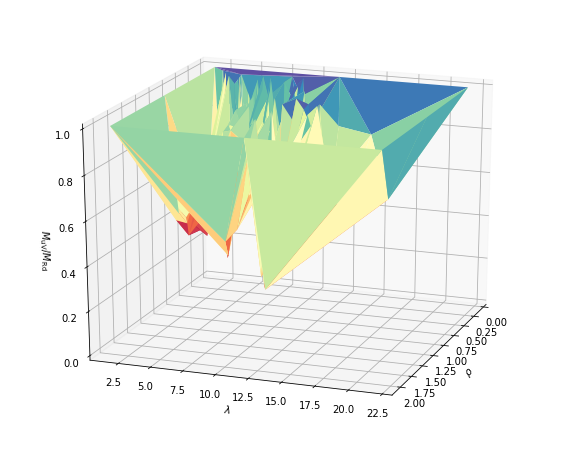

In [6]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(1, 1, 1, projection='3d')
x, y, z = xyz.T
ax.plot_trisurf(x, y, z, triangles=triangles, cmap=plt.cm.Spectral)
ax.set_xlabel(r'$\rho$')
ax.set_ylabel(r'$\lambda$')
ax.set_zlabel(r'$M_\mathrm{uV} / M_\mathrm{Rd}$')
ax.view_init(20, 20)
ax.set_zlim(0,1);

# Plot using ipyvolume
Package for 3D plotting combined with ipywidgets for interaction
It is really meant for volumes and not functions.

In [7]:
ipv.figure(width=700, height=500)
# we draw the tetrahedron
mesh = ipv.plot_trisurf(x, y, z, triangles=tri.simplices, color='orange')
# and also mark the vertices
ipv.scatter(x, y, z, marker='sphere', color='blue')
ipv.zlim(0, 1)
ipv.view(azimuth=90, elevation=90, distance=3)
ipv.ylabel('lambda')
ipv.xlabel('rho')
ipv.zlabel('MuV / MRd')
ipv.show()
def update(a,e):
    ipv.view(azimuth=a, elevation=e)

ipw.interact(update,a=ipw.FloatSlider(min=-180, max=180),
             e=ipw.FloatSlider(min=-180, max=180));

interactive(children=(FloatSlider(value=0.0, description='a', max=180.0, min=-180.0), FloatSlider(value=0.0, d…

# Least square fitting
This is just a sketch - something more advanced is needed. Maybe some inspiration is here:


In [8]:
import scipy.linalg

In [9]:
# Create data with x and y random over [-2, 2], and z a Gaussian function of x and y.
#np.random.seed(12345)
#x = 2 * (np.random.random(500) - 0.5)
#y = 2 * (np.random.random(500) - 0.5)

#def f(x, y):
#    return np.exp(-(x + y ** 2))
#
#z = f(x, y)

data = xyz

# regular grid covering the domain of the data
mn = np.min(data, axis=0)
mx = np.max(data, axis=0)
X,Y = np.meshgrid(np.linspace(mn[0], mx[0], 20), np.linspace(mn[1], mx[1], 20))
XX = X.flatten()
YY = Y.flatten()
    
# best-fit linear plane (1st-order)
A = np.c_[data[:,0], data[:,1], np.ones(data.shape[0])]
C,_,_,_ = scipy.linalg.lstsq(A, data[:,2])    # coefficients
    
# evaluate it on grid
Z = C[0]*X + C[1]*Y + C[2]
    
# or expressed using matrix/vector product
#Z = np.dot(np.c_[XX, YY, np.ones(XX.shape)], C).reshape(X.shape)

In [10]:
# best-fit quadratic curve (2nd-order)
A = np.c_[np.ones(data.shape[0]), data[:,:2], np.prod(data[:,:2], axis=1), data[:,:2]**2]
C,_,_,_ = scipy.linalg.lstsq(A, data[:,2])
    
# evaluate it on a grid
Z = np.dot(np.c_[np.ones(XX.shape), XX, YY, XX*YY, XX**2, YY**2], C).reshape(X.shape)

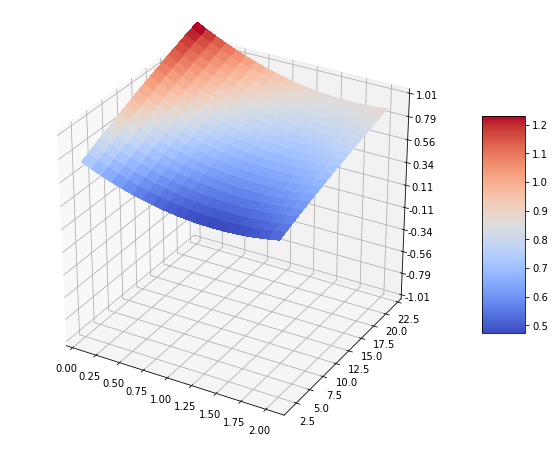

In [11]:
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(1, 1, 1, projection='3d')

surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()